### Presets

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True,
transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True,
transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
batch_size=64, shuffle=False)

##### Model definitions

In [20]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout = nn.Dropout(0.3)  # 2.a add dropout layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x) # 2.a add dropout layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
model = NeuralNet()

##### Loss and optimizer 

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
# Optimizer with L2 regularization (Regularization b) and momentum (Momentum a)
l2_lambda = 0.001
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=l2_lambda, momentum=0.9) # 4.a add momentum

##### Training loop

In [24]:
# Training settings
num_epochs = 10
l1_lambda = 0.001  # L1 regularization lambda (Regularization a)

train_losses = []   # List to store training losses
val_losses = []     # List to store validation losses
test_accuracies = [] # List to store test accuracies

In [25]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the epoch
    
    # Training loop
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass: compute the model output
        loss = criterion(outputs, targets)  # Compute the loss
        
        # L1 regularization penalty
        l1_norm = sum(p.abs().sum() for p in model.fc2.parameters())
        loss += l1_lambda * l1_norm
        
        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Optimize the weights based on gradients
        running_loss += loss.item()  # Accumulate the loss for the batch

    # Track average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize validation loss
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in test_loader:
            outputs = model(inputs)  # Forward pass: compute the model output
            loss = criterion(outputs, targets)  # Compute validation loss
            val_loss += loss.item()  # Accumulate validation loss
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the maximum log-probability
            total += targets.size(0)  # Update total predictions count
            correct += (predicted == targets).sum().item()  # Update correct predictions count

    avg_val_loss = val_loss / len(test_loader)  # Calculate average validation loss
    val_losses.append(avg_val_loss)  # Store average validation loss
    test_accuracy = 100 * correct / total  # Calculate accuracy as a percentage
    test_accuracies.append(test_accuracy)  # Store accuracy
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

Epoch [1/10], Training Loss: 0.8654, Validation Loss: 0.2890, Accuracy: 91.68%
Epoch [2/10], Training Loss: 0.4156, Validation Loss: 0.2146, Accuracy: 93.68%
Epoch [3/10], Training Loss: 0.3471, Validation Loss: 0.1817, Accuracy: 94.48%
Epoch [4/10], Training Loss: 0.3104, Validation Loss: 0.1590, Accuracy: 95.24%
Epoch [5/10], Training Loss: 0.2878, Validation Loss: 0.1452, Accuracy: 95.81%
Epoch [6/10], Training Loss: 0.2701, Validation Loss: 0.1305, Accuracy: 96.11%
Epoch [7/10], Training Loss: 0.2577, Validation Loss: 0.1245, Accuracy: 96.28%
Epoch [8/10], Training Loss: 0.2457, Validation Loss: 0.1204, Accuracy: 96.63%
Epoch [9/10], Training Loss: 0.2388, Validation Loss: 0.1162, Accuracy: 96.67%
Epoch [10/10], Training Loss: 0.2342, Validation Loss: 0.1129, Accuracy: 96.74%


##### Plotting 

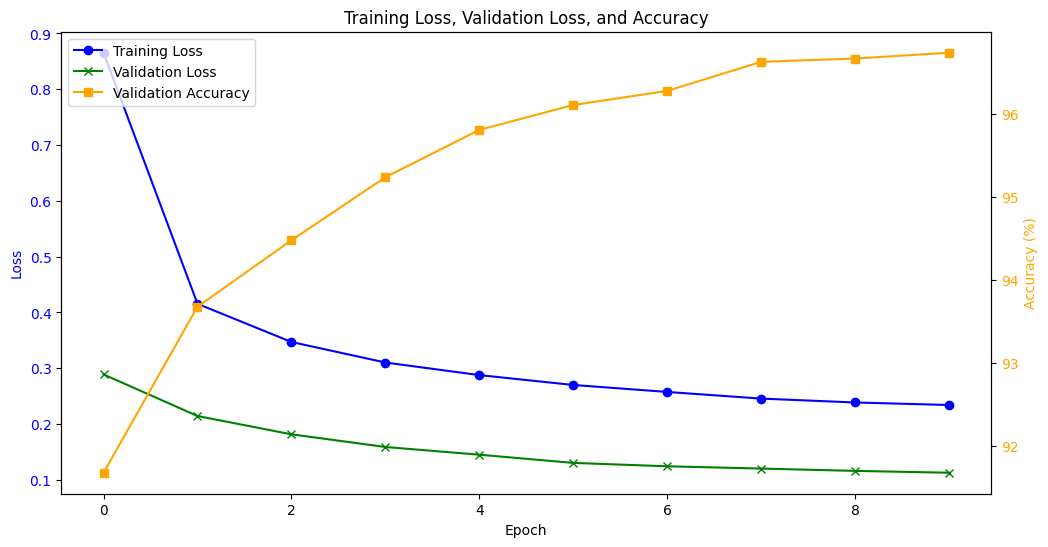

In [27]:
plt.figure(figsize=(12, 6))

train_loss_line, = plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
val_loss_line, = plt.plot(val_losses, label='Validation Loss', color='green', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss', color='blue')
plt.tick_params(axis='y', labelcolor='blue')
ax2 = plt.gca().twinx()
accuracy_line, = ax2.plot(test_accuracies, label='Validation Accuracy', color='orange', marker='s')
ax2.set_ylabel('Accuracy (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
lines = [train_loss_line, val_loss_line, accuracy_line]
labels = [line.get_label() for line in lines]
plt.title('Training Loss, Validation Loss, and Accuracy')
plt.legend(lines, labels, loc='upper left')
plt.savefig('Optimal values l1,l2 = 0.001, 128 neurons, 3 layers, mom=0.9, dropout = 0.3 .png') 
plt.show()